In [20]:
import pandas as pd
import yfinance as yf
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, RepeatVector, TimeDistributed, LayerNormalization
from sklearn.preprocessing import MinMaxScaler

# Fetch data from Yahoo Finance
data = yf.download("BTC-USD", start="2024-11-01", end="2024-12-01", interval="15m")

# Preprocess data
data.dropna(inplace=True)
data['Close'] = data['Close'].astype(float)

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

# Function to create dataset
def create_dataset(dataset, look_back=60):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

look_back = 60
X, y = create_dataset(scaled_data, look_back)

# Reshape X to 3D array for LSTM (samples, time steps, features)
X = X.reshape(X.shape[0], X.shape[1], 1)

# Temporal Attention Layer (custom layer)
# Updated TemporalAttention Layer with increased number of parameters
# Updated TemporalAttention Layer with more parameters
# Updated TemporalAttention Layer with even more parameters
class TemporalAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(TemporalAttention, self).__init__()
        self.d_model = d_model
        self.num_heads = num_heads

    def build(self, input_shape):
        self.query_dense = Dense(self.d_model)
        self.key_dense = Dense(self.d_model)
        self.value_dense = Dense(self.d_model)

    def call(self, inputs):
        # Ensure inputs are cast to float32
        inputs = tf.cast(inputs, tf.float32)

        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)

        # Split the last dimension into (num_heads, depth)
        query = tf.reshape(query, (tf.shape(query)[0], -1, self.num_heads, self.d_model // self.num_heads))
        key = tf.reshape(key, (tf.shape(key)[0], -1, self.num_heads, self.d_model // self.num_heads))
        value = tf.reshape(value, (tf.shape(value)[0], -1, self.num_heads, self.d_model // self.num_heads))

        # Scaled dot-product attention
        attention_scores = tf.matmul(query, key, transpose_b=True) / tf.sqrt(tf.cast(self.d_model, tf.float32))
        attention_weights = tf.nn.softmax(attention_scores, axis=-1)
        output = tf.matmul(attention_weights, value)

        # Concatenate the heads and reshape to original shape
        output = tf.reshape(output, (tf.shape(output)[0], -1, self.d_model))

        return output

# Model Architecture with significantly more parameters in the Transformer part
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(look_back, 1)))
model.add(RepeatVector(48))  # Adjust the number of time steps (48 for 48 hours prediction)
model.add(TemporalAttention(400, 64))  # Increased d_model to 400 and num_heads to 64
model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile(loss='mse', optimizer='adam')
model.summary()
# Model Training
model.fit(X, y, epochs=5, batch_size=32, validation_split=0.2)

# Prepare the last 60 hours of data for prediction
last_60_hours = scaled_data[-60:]
X_test = last_60_hours.reshape((1, look_back, 1))

# Predict the next 48 hours
y_pred = model.predict(X_test)

# Inverse transform to get original price scale
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))  # Reshape the predictions before inverse transforming

print(y_pred)


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_19 (LSTM)                       │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_11 (RepeatVector)      │ (None, 48, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ temporal_attention_9                 │ (None, None, 400)           │          61,200 │
│ (TemporalAttention)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_20 (LSTM)                       │ (None, None, 50)            │          90,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_8 (TimeDistributed) │ (None, None, 1)             │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 161,851 (632.23 KB)

 Trainable params: 161,851 (632.23 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 26s 294ms/step - loss: 0.2042 - val_loss: 0.0703
Epoch 2/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 40s 286ms/step - loss: 0.1057 - val_loss: 0.1150
Epoch 3/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 19s 267ms/step - loss: 0.1026 - val_loss: 0.1062
Epoch 4/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 20s 283ms/step - loss: 0.1057 - val_loss: 0.0839
Epoch 5/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 19s 269ms/step - loss: 0.1024 - val_loss: 0.1046
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step
[[80496.94 ]
 [85335.95 ]
 [86587.95 ]
 [86483.24 ]
 [86294.56 ]
 [85970.2  ]
 [85661.484]
 [85647.79 ]
 [85531.97 ]
 [85485.15 ]
 [85528.67 ]
 [85511.47 ]
 [85522.41 ]
 [85545.1  ]
 [85501.3  ]
 [85401.61 ]
 [85259.13 ]
 [85145.06 ]
 [85066.94 ]
 [85108.13 ]
 [85217.516]
 [85143.77 ]
 [85177.93 ]
 [85420.72 ]
 [86803.58 ]
 [86583.31 ]
 [85790.39 ]
 [85009.516]
 [84671.85 ]
 [84483.73 ]
 [84400.3  ]
 [84606.15 ]
 [84683.67 ]
 [84804.69 ]
 [84989.44 ]
 [85083.1  ]
 [85186.08 ]
 [85283.37 ]
 [85298.75 ]
 [85244.625]
 [85137.91 

[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_23 (LSTM)                       │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_13 (RepeatVector)      │ (None, 48, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ temporal_attention_11                │ (None, None, 400)           │          61,200 │
│ (TemporalAttention)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_24 (LSTM)                       │ (None, None, 50)            │          90,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_10                  │ (None, None, 1)             │              51 │
│ (TimeDistributed)                    │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 161,851 (632.23 KB)

 Trainable params: 161,851 (632.23 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 22s 483ms/step - loss: 0.2495 - val_loss: 0.1093
Epoch 2/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 482ms/step - loss: 0.1111 - val_loss: 0.1394
Epoch 3/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 18s 499ms/step - loss: 0.1065 - val_loss: 0.1067
Epoch 4/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 19s 475ms/step - loss: 0.1070 - val_loss: 0.1455
Epoch 5/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 503ms/step - loss: 0.1044 - val_loss: 0.1173
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 848ms/step


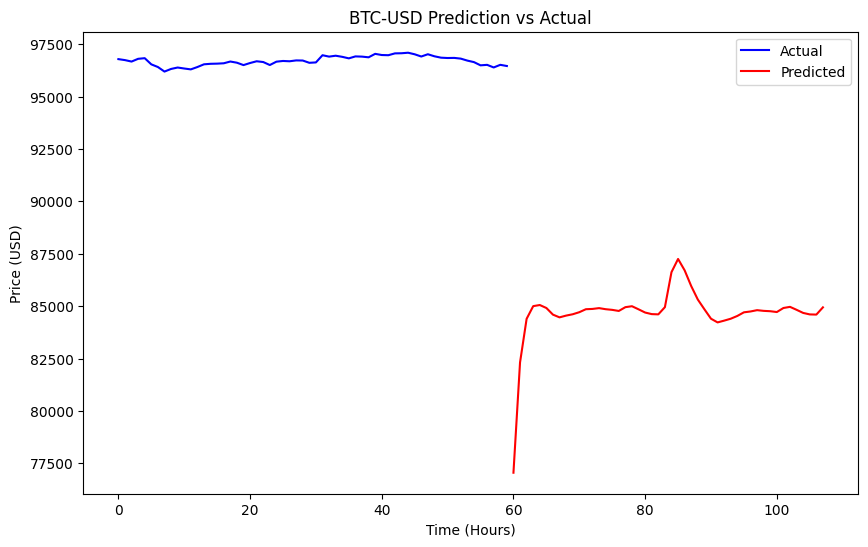

In [22]:
import pandas as pd
import yfinance as yf
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, Dense, TimeDistributed
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Fetch data from Yahoo Finance
data = yf.download("BTC-USD", start="2024-11-01", end="2024-12-01", interval="15m")

# Preprocess data
data.dropna(inplace=True)
data['Close'] = data['Close'].astype(float)

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

def create_dataset(dataset, look_back=60):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

look_back = 60
X, y = create_dataset(scaled_data, look_back)

# TemporalAttention Layer (adjusted for more parameters)
class TemporalAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(TemporalAttention, self).__init__()
        self.d_model = d_model
        self.num_heads = num_heads

    def build(self, input_shape):
        self.query_dense = Dense(self.d_model)
        self.key_dense = Dense(self.d_model)
        self.value_dense = Dense(self.d_model)

    def call(self, inputs):
        inputs = tf.cast(inputs, tf.float32)
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)

        query = tf.reshape(query, (tf.shape(query)[0], -1, self.num_heads, self.d_model // self.num_heads))
        key = tf.reshape(key, (tf.shape(key)[0], -1, self.num_heads, self.d_model // self.num_heads))
        value = tf.reshape(value, (tf.shape(value)[0], -1, self.num_heads, self.d_model // self.num_heads))

        attention_scores = tf.matmul(query, key, transpose_b=True) / tf.sqrt(tf.cast(self.d_model, tf.float32))
        attention_weights = tf.nn.softmax(attention_scores, axis=-1)
        output = tf.matmul(attention_weights, value)

        output = tf.reshape(output, (tf.shape(output)[0], -1, self.d_model))
        return output

# Model Architecture with significantly more parameters in the Transformer part
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(look_back, 1)))
model.add(RepeatVector(48))  # Adjust the number of time steps (48 for 48 hours prediction)
model.add(TemporalAttention(400, 64))  # Increased d_model to 400 and num_heads to 64
model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile(loss='mse', optimizer='adam')
model.summary()
# Model Training
model.fit(X, y, epochs=5, batch_size=64, validation_split=0.2)

# Prepare the last 60 hours of data for prediction
last_60_hours = scaled_data[-60:]
X_test = last_60_hours.reshape((1, look_back, 1))

# Predict the next 48 hours
y_pred = model.predict(X_test)

# Inverse transform to get original price scale
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))  # Reshape the predictions before inverse transforming

# Plotting the predicted vs actual values
# For visualization, we also need the actual values to compare with predictions
actual_values = data['Close'].values[-look_back:]  # Take the last 60 actual values for comparison

# Create a plot
plt.figure(figsize=(10, 6))
plt.plot(range(len(actual_values)), actual_values, color='blue', label='Actual')
plt.plot(range(len(actual_values), len(actual_values) + len(y_pred)), y_pred, color='red', label='Predicted')
plt.title('BTC-USD Prediction vs Actual')
plt.xlabel('Time (Hours)')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()


In [24]:
import pandas as pd
import yfinance as yf
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, Dense, TimeDistributed
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Fetch data from Yahoo Finance
data = yf.download("BTC-USD", start="2024-11-01", end="2024-12-01", interval="15m")

# Preprocess data
data.dropna(inplace=True)
data['Close'] = data['Close'].astype(float)

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

def create_dataset(dataset, look_back=60):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

look_back = 60
X, y = create_dataset(scaled_data, look_back)

# TemporalAttention Layer (adjusted for more parameters)
class TemporalAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(TemporalAttention, self).__init__()
        self.d_model = d_model
        self.num_heads = num_heads

    def build(self, input_shape):
        self.query_dense = Dense(self.d_model)
        self.key_dense = Dense(self.d_model)
        self.value_dense = Dense(self.d_model)

    def call(self, inputs):
        inputs = tf.cast(inputs, tf.float32)
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)

        query = tf.reshape(query, (tf.shape(query)[0], -1, self.num_heads, self.d_model // self.num_heads))
        key = tf.reshape(key, (tf.shape(key)[0], -1, self.num_heads, self.d_model // self.num_heads))
        value = tf.reshape(value, (tf.shape(value)[0], -1, self.num_heads, self.d_model // self.num_heads))

        attention_scores = tf.matmul(query, key, transpose_b=True) / tf.sqrt(tf.cast(self.d_model, tf.float32))
        attention_weights = tf.nn.softmax(attention_scores, axis=-1)
        output = tf.matmul(attention_weights, value)

        output = tf.reshape(output, (tf.shape(output)[0], -1, self.d_model))
        return output

# Model Architecture with significantly more parameters in the Transformer part
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(look_back, 1)))
model.add(RepeatVector(48))  # Adjust the number of time steps (48 for 48 hours prediction)
model.add(TemporalAttention(400, 64))  # Increased d_model to 400 and num_heads to 64
model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile(loss='mse', optimizer='adam')
model.summary()
# Model Training
model.fit(X, y, epochs=6, batch_size=64, validation_split=0.2)

# Prepare the last 60 hours of data for prediction (from the most recent data point)
last_60_hours = scaled_data[-look_back:].reshape((1, look_back, 1))

# Predict the next 48 hours, step by step
predictions = []
current_input = last_60_hours

for _ in range(48):  # Predict for the next 48 hours
    pred = model.predict(current_input)
    predictions.append(pred[0, 0, 0])  # Get the first value from the batch
    current_input = np.roll(current_input, -1, axis=1)  # Shift the input data
    current_input[0, -1, 0] = pred  # Add the predicted value as the last input

# Inverse transform the predicted values to original price scale
predictions = np.array(predictions).reshape(-1, 1)
predictions = scaler.inverse_transform(predictions)

# Plotting the predicted values for the next 48 hours
plt.figure(figsize=(10, 6))
plt.plot(range(len(data['Close'])), data['Close'].values, color='blue', label='Actual')  # Plot actual data
plt.plot(range(len(data['Close']), len(data['Close']) + len(predictions)), predictions, color='red', label='Predicted')
plt.title('BTC-USD Prediction from 01.12.2024 for Next 48 Hours')
plt.xlabel('Time (Hours)')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/6
36/36 ━━━━━━━━━━━━━━━━━━━━ 30s 701ms/step - loss: 0.2542 - val_loss: 0.0943
Epoch 2/6
36/36 ━━━━━━━━━━━━━━━━━━━━ 19s 529ms/step - loss: 0.1087 - val_loss: 0.1505
Epoch 3/6
36/36 ━━━━━━━━━━━━━━━━━━━━ 18s 491ms/step - loss: 0.1062 - val_loss: 0.1317
Epoch 4/6
36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 503ms/step - loss: 0.1046 - val_loss: 0.0906
Epoch 5/6
36/36 ━━━━━━━━━━━━━━━━━━━━ 19s 516ms/step - loss: 0.1043 - val_loss: 0.1315
Epoch 6/6
36/36 ━━━━━━━━━━━━━━━━━━━━ 19s 486ms/step - loss: 0.1014 - val_loss: 0.1159
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 957ms/step


ValueError: setting an array element with a sequence.